In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import os
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
import mrc as mrc
import statistics
import imageio
import ctf
import pickle
import copy
import time
#import skimage
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
path = 'C:\\Users\\nadav\\Desktop\\cryo_em_lab\\Part 3 - Comparing Structures'

#Second verison of comparison:
The below code is the same as the previous version, but with the zero stack implicit and avoiding the unnecessary calculation. 
For the sigma caluclation, the number of itterations has been upped to 50 of 100 points. 
Also, a checker for the length of P(Tk) has been implemented. 
The img_norm term was creating some blocking effect, so it was omitted occasionally, but if included it does cance with P(I|Tk), resulting in an unblocked probability P(Tk|I). 
The Ek equivalence for the zero stack is:
ek_stack[-1,:,:] = 1/(2\*sigma\*\*2)\*fast_convolve(I\*\*2, padding) - np.log(z)


In [27]:
%%time
#Version 3 - Taking in a folder with stacks of a particle in different configurations and producing probabilities.
#Implementing sigma as a parameter and estimation.

def Config_Prob(I, folder, max_num = 10, method = 1, sigma = None, psk = []):
    
    if sigma is None:
        #Calculate variance for 5 points, 10 times and take median
        avg_num = 50
        sample_num = 100
        sigma_list = np.empty([avg_num,1])
        for nn in range(avg_num):

            x = np.random.randint(0, h, size = sample_num)
            y = np.random.randint(0,l, size = sample_num)
            vbar = 0
            
            for mm in range(sample_num):
                vbar = vbar + I[x[mm]][y[mm]]
                
            sigma = 0
            vbar = vbar * 1/sample_num
            
            for mm in range(sample_num):
                sigma = sigma + (I[x[mm]][y[mm]]- vbar)**2
                
            sigma = sigma * 1/sample_num
            sigma_list[nn] = np.sqrt(sigma)
            
        sigma = np.median(sigma_list)
        
    else:
        None
        
    print('Sigma is ' + str(sigma))
    
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
        
    ek_stack = np.empty([num_configs + 1, h, l])
    prob_stack = np.empty([num_configs + 1, h, l])
    prob_stack2 = np.empty([num_configs + 1, h, l])
    
    padding = np.zeros_like(I)
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    x,y,z = mrc.readMRC(os.path.join(folder, os.listdir(folder)[0])).shape
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            #error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l, sigma, x, y, z, xcent, ycent, f2)
            error_stack = Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma)
            
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('outerloop')
    
        
        ek_stack[-1,:,:] = 1/(2*sigma**2)*fast_convolve(I**2, padding) - np.log(z)
        
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
               
        
        for temp_stack in range(len(os.listdir(folder))+1):
            
            
            prob = (ek_stack[temp_stack,:,:] + ek_sum)
            
            prob_stack[temp_stack,:,:] = prob
            
            prob_stack2[temp_stack,:,:] = np.exp(-prob)
            
        return (prob_stack, ek_stack, ek_sum, prob_stack2) 
    
    else:
        if not len(psk) == len(os.listdir(folder)):
            raise Exception('PSK length needs to equal template stack number')
                    
        count = 0
        
       
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma)
            
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('outerloop')
            
        ek_stack[-1,:,:] = 1/(2*sigma**2)*fast_convolve(I**2, padding) - np.log(z)
            
        for temp_stack in range(len(os.listdir(folder)) + 1):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
            
            prob_stack[temp_stack,:,:] = prob
            prob_stack2[temp_stack,:,:] = np.exp(-prob)
        
        return (prob_stack, ek_stack, ek_sum, prob_stack2)
        
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num, sigma)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
          
        ejk_stack = np.empty([max_num,h, l])
        
        img_norm = fast_convolve(I**2, padding, PFT = f2)

        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):

                temp = zed[:,:,xx]
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                temp_norm = np.sum(temp**2)        
                
                
                #ejk_stack[xx,:,:] = (1/(2*sigma**2))*(temp_norm - 2*crossc)
                ejk_stack[xx,:,:] = (1/(2*sigma**2))*(img_norm + temp_norm - 2*crossc)
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('innerloop')
           
        
        return ejk_stack_2
                       
    
def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is None:
        
        IFT = np.fft.rfft2(I)

    if PFT is None:
        PFT = np.fft.rfft2(T)

    fc = np.fft.fftshift(np.fft.irfft2(IFT*PFT)) 
   
    return fc        
    
z2 = Config_Prob('imgdata_30008_1.mrc', os.path.join(path,'test_folder_2'), psk = [0.1, 0.9, 0.8], method = 1, sigma = 24.9180918)

Sigma is 24.9180918
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
Wall time: 5min 30s


Implementation of CTF in the proper way, where 
$$ \sum_\omega||(\tilde{I}_\omega-\tilde{C}_\omega \tilde{T}_\omega)||^2 = \tilde{I}^*\tilde{I} + \tilde{C}^2\tilde{T}\tilde{T}^* -2\tilde{C}\mathbb{R}[\tilde{T}^*\tilde{I}] $$
where \* is the complex conjugate of the corresponding image. 

The data type for all arryas is complex, as is the result. 
When taking the Fourier transforms, the real transfomr was not used, and orthogonal normalization was used, this accounts for the scaling between the transform and the sigma factor. 
This code also contains a zero-stack element, ek_stack[-1,:,:] = (1/(2\*sigma\*\*2)\*f1\*np.conj(f1)) - np.log(z) where f1 is the image. 
Ejk = (1/(2\*sigma\*\*2))\*(f1_c\*f1 + f3\*ft_c\*ft - 2\*f3\*np.real(ft_c\*f1)), where _c denotes a conjugate. 

In [30]:
%%time
#Adding the CTF functionality, where you input microscope parameters and get CTF correct probabilities
def Config_Prob(I, folder, rots, psize, akv, csf, wgh, df1, df2, ang, dscale, 
                bfactor, max_num = 10, method = 1, sigma = None, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
    
    if sigma is None:
        #Calculate variance for 5 points, 10 times and take median
        avg_num = 50
        sample_num = 100
        sigma_list = np.empty([avg_num,1])
        for nn in range(avg_num):

            x = np.random.randint(0, h, size = sample_num)
            y = np.random.randint(0,l, size = sample_num)
            vbar = 0
            
            for mm in range(sample_num):
                vbar = vbar + I[x[mm]][y[mm]]
                
            sigma = 0
            vbar = vbar * 1/sample_num
            
            for mm in range(sample_num):
                sigma = sigma + (I[x[mm]][y[mm]]- vbar)**2
                
            sigma = sigma * 1/sample_num
            sigma_list[nn] = np.sqrt(sigma)
            
        sigma = statistics.median(sigma_list)[0]
        
        
    else:
        None
        
    print(sigma)
        
    ek_stack = np.empty([num_configs + 1, h, l], dtype = complex)
    prob_stack = np.empty([num_configs + 1, h, l], dtype = complex)
    
    mask = np.zeros_like(I)
    
    f1 = np.fft.fft2(I, norm = 'ortho')
    
    x,y,z = mrc.readMRC(os.path.join(folder, os.listdir(folder)[0])).shape
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    CTF_effect = ctf.compute_full_ctf(None, x, psize, akv, csf, wgh, df1, df2, ang, dscale, bfactor).reshape([x,x])
    
    CTF = np.zeros_like(I)
    
    CTF[xcent:xcent+int(x), ycent:ycent+int(y)] = CTF_effect
    
    f3 = (np.fft.fft2(CTF, norm = 'ortho'))
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f3, mask, max_num, sigma)
            
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = (config_error)
            count += 1 
            
            print('outerloop')
      
        ek_stack[-1,:,:] = (1/(2*sigma**2)*f1*np.conj(f1)) - np.log(z)
       
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
                 
        
        for temp_stack in range(len(os.listdir(folder))+1):
            
            
            prob = (ek_stack[temp_stack,:,:] + ek_sum)
            
            prob_stack[temp_stack,:,:] = prob
            
            
        return (prob_stack, ek_stack, ek_sum)
    
    
    else:
        if not len(psk) == len(os.listdir(folder)):
            raise Exception('PSK length needs to equal template stack number')
        count = 0
        
       
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f3, mask, max_num, sigma)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('outerloop')
            
        ek_stack[-1,:,:] = (1/(2*sigma**2)*f1*np.conj(f1)) - np.log(z)
            
        for temp_stack in range(len(os.listdir(folder))+1):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
          
            prob_stack[temp_stack,:,:] = prob
        
        return (prob_stack, ek_stack, ek_sum)

def Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f3, mask, max_num, sigma, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, f3, padding, mask, max_num, sigma)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l], dtype = complex)
          
        ejk_stack = np.empty([max_num,h, l], dtype=complex)
        
        f1_c = np.conj(f1)
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l], dtype = complex)      
            
            for xx in range(zed.shape[2]):

                temp = zed[:,:,xx]
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                ft = np.fft.fft2(mask, norm = 'ortho')
                
                ft_c = np.conj(ft)
                
                Q = (1/(2*sigma**2))*(f1_c*f1 + f3*ft_c*ft - 2*f3*np.real(ft_c*f1))
                
                ejk_stack[xx,:,:] = (Q)
                
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('innerloop')
           
        return ejk_stack_2
    
def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is None:
        IFT = np.fft.rfft2(I)

    if PFT is None:
        PFT = np.fft.rfft2(T)

    fc = np.fft.fftshift(np.fft.irfft2(IFT*PFT)) 
   
    return fc        

    
z3 = Config_Prob('imgdata_30008_1.mrc', os.path.join(path,'test_folder_2'), None, 2, 300, 2.0, 0.1, 11000, 13000, 0, 1, 10.0,  psk = [0.1, 0.9], method = 1, sigma = 24.918)

24.918
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
outerloop
Wall time: 7min 40s


Testing different combinations of the CTF calculation, hoping one of them works. Th output is a weirdly static image, not sure what to make of it. Needs inspection.


[[1.14084475e+02+0.j 5.72791278e-01+0.j 1.13241561e+00+0.j ...
  1.21023616e+00+0.j 1.13241561e+00+0.j 5.72791278e-01+0.j]
 [1.40890477e+00+0.j 5.77336615e-01+0.j 1.72780266e+00+0.j ...
  4.37484842e+00+0.j 5.06957755e-01+0.j 3.71824683e-01+0.j]
 [5.77870266e+00+0.j 2.28704002e-02+0.j 9.07394968e-01+0.j ...
  2.84496777e+00+0.j 5.17245944e-02+0.j 7.11878931e-01+0.j]
 ...
 [5.05813395e+00+0.j 3.17419832e+00+0.j 2.42088520e+00+0.j ...
  8.51570535e-01+0.j 4.66631599e-01+0.j 1.95654203e+00+0.j]
 [5.77870266e+00+0.j 7.11878931e-01+0.j 5.17245944e-02+0.j ...
  1.05132763e-01+0.j 9.07394968e-01+0.j 2.28704002e-02+0.j]
 [1.40890477e+00+0.j 3.71824683e-01+0.j 5.06957755e-01+0.j ...
  4.53457884e-01+0.j 1.72780266e+00+0.j 5.77336615e-01+0.j]]
(114.08447478104297+0j) (3.264573861894221e-09+0j) (0.501673318517112+0j)


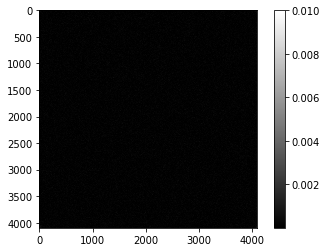

In [2]:
#Testing CTF stuff
I = mrc.readMRC('imgdata_30008_1.mrc')[:,:,0]
temp = mrc.readMRC(os.path.join(path, 'test_folder_2\\28001_20.mrc'))
h,l = I.shape
sigma = 24.918

x,y,z = temp.shape
xcent = int(h/2-x/2)
ycent = int(l/2-y/2)
CTF_effect = ctf.compute_full_ctf(None, x, 2, 300, 2.0, 0.1, 11000,13000, 0, 1, 10.0).reshape([x,x])
    
CTF = np.zeros_like(I)
mask = np.zeros_like(I)
    
CTF[xcent:xcent+int(x), ycent:ycent+int(y)] = CTF_effect
    
zed = temp[:,:,0]
zed.shape

mask[xcent:xcent+int(x), ycent:ycent+int(y)] = zed[::-1,::-1] 

f1 = np.fft.fft2(I, norm = 'ortho') #image
f2 = np.fft.fft2(CTF, norm = 'ortho') #CTF
f3 = np.fft.fft2(mask, norm = 'ortho') #Template

f1_c = np.conj(f1) #Image FT conjugate
f2 = np.real(f2) #Real part of CTF
f3_c = np.conj(f3) #Template FT conjugate

                   
a = f1_c*f1 #Image normalization
b = f2**2*f3_c*f3 #Template normalization
c = -2*f2*np.real(f3_c*f1) #Cross term

test = (1/(2*sigma**2))*(a)
print(test)
plt.figure()
plt.imshow(np.abs(np.fft.ifft2(test)), vmax=0.01)

plt.colorbar()

#scipy.misc.imsave('lookhere.png', np.abs(test))
print(np.amax(test), np.amin(test), np.mean(test))

In [1]:
def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is None:
        IFT = np.fft.rfft2(I)

    if PFT is None:
        PFT = np.fft.rfft2(T)

    fc = np.fft.fftshift(np.fft.irfft2(IFT*PFT)) 
   
    return fc        


img = mrc.readMRC('imgdata_30008_1.mrc')
img = img[:,:,0]
template = mrc.readMRC('test_folder_2/28001_20.mrc')
temp = template[:,:,0]
#noisy_image = G = np.random.normal(0,1,16777216).reshape([4096,4096])

#From micrograph data
sigma = 24.9

padding = np.zeros_like(img)
padding[1536:2560,1536:2560] = 1

img_norm = fast_convolve(img**2, padding)
temp_norm = np.sum(temp**2)

temp_pad = np.zeros_like(img)
temp_pad[1536:2560,1536:2560] = temp[::-1,::-1]

cross_corr = fast_convolve(img, temp_pad)
normalized_cross_corr = 1/(2*sigma**2)*(img_norm + temp_norm - 2*cross_corr)

#CTF affected code

#def compute_full_ctf(rots,N,psize,akv,csf,wgh,dfmid1,dfmid2,angastf,dscale,bfactor)
CTF_effect = ctf.compute_full_ctf(None, 1024, 2.0,300, 2, 0.1, 12000, 12000,  0, 1, 10).reshape([1024,1024])
CTF = np.zeros_like(img)
CTF[1536:2560,1536:2560] = CTF_effect

fourier_image = np.fft.rfft2(img)
fourier_ctf = np.fft.rfft2(CTF)
fourier_temp = np.fft.rfft2(temp_pad)

img_norm_ctf = fourier_image**2
temp_norm_ctf = (fourier_ctf*fourier_temp)**2
cross_corr_ctf = -2*fourier_image*fourier_ctf*fourier_temp
normalized_cross_corr_ctf =  1/(2*sigma**2)*np.fft.irfft2(img_norm_ctf + temp_norm_ctf + cross_corr_ctf)
#reverted from Fourier space using np.fft.rfft2()

#Same code tested on a unifromaly noisy micrograph, sigma = 1, mu = 0
img_norm_noisy = fast_convolve(noisy_image**2, padding)
cross_corr_noisy = fast_convolve(noisy_image, temp_pad)
normalized_cross_corr_noisy = 1/(2)*(img_norm_noisy + temp_norm - 2*cross_corr_noisy)

fourier_image_noisy = np.fft.rfft2(noisy_image)

img_norm_ctf_noisy = fourier_image_noisy**2
cross_corr_ctf_noisy = -2*fourier_image_noisy*fourier_ctf*fourier_temp
normalized_cross_corr_ctf_noisy =  1/(2)*np.fft.irfft2(img_norm_ctf_noisy + temp_norm_ctf + cross_corr_ctf_noisy)


# image = (normalized_cross_corr_ctf_noisy)


# plt.figure()
# plt.imshow(image)
# plt.colorbar()
# scipy.misc.imsave('normalized_cross_correlation_ctf_noisy.png', image)

NameError: name 'mrc' is not defined

In [31]:
np.save('30008_CTF_20.npy', z3)

Code for creating plots that compare values of different images.

IndexError: index 4 is out of bounds for axis 0 with size 4

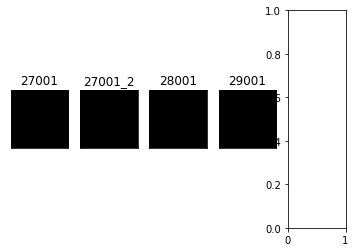

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 5)

count = 0
names = ['27001','27001_2', '28001', '29001', 'Zero Stack']
for ax in axes.flat:
    im = ax.imshow(np.abs(np.fft.ifft2(z3[0][count])))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(names[count])
    count += 1
for nn in range(len(names)):
    print(names[nn] + ' Max is: ' + str(np.amax(z2[1][nn])) + ' Min is: ' + str(np.amin(z2[1][nn])) + ' Median is: ' + str(np.median(z2[1][nn])) + ' Mean is: ' + str(np.mean(z2[1][nn])))
fig.subplots_adjust(right = 0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)

#plt.savefig('30008_neglogprob_5.pdf',format = 'pdf', dpi = 2000)
plt.show()
#plt.savefig('heythere.png')
#scipy.misc.imsave('zero_stack_CTF.png', z3[0][3])
#print(np.amax(z3[0][3]))


TypeError: Image data cannot be converted to float

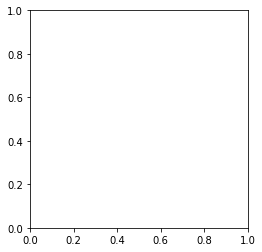

In [36]:
Pre = np.exp(-z3[0][0]) + np.exp(-z3[0][1]) + np.exp(-z3[0][2]) + np.exp(-z3[0][3])

plt.figure()
plt.imshow(Pre, vmin = 0.9, vmax = 1.1)
plt.colorbar()

# plt.savefig('neg_exp_sum.png', dpi=500)
# print(Pre[12067530//4096, 12067530%4096])
# Pre[12067530//4096, 12067530%4096] = 1
# Pre[12071626//4096, 12071626%4096] = 1
# Pre[13138828//4096, 13138828%4096] = 1
# Pre[13138829//4096,13138829%4096] = 1
# Pre[931721//4096, 931721%4096] = 1
print(np.amax(Pre), np.amin(Pre), np.sum(Pre), np.mean(Pre))
#scipy.misc.imsave('hey_CTF.png', Pre)

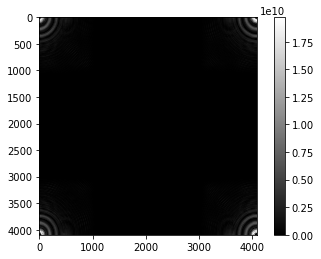

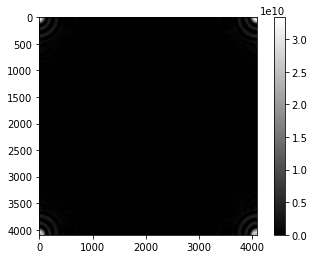

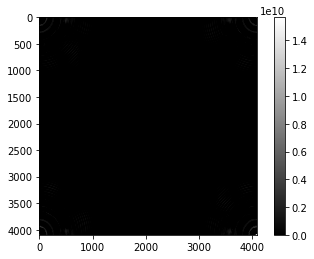

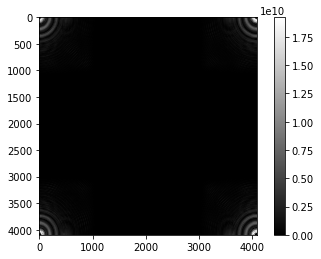

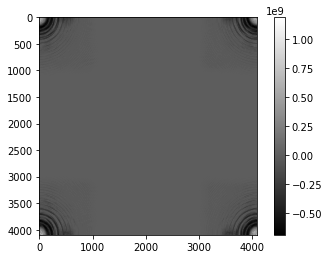

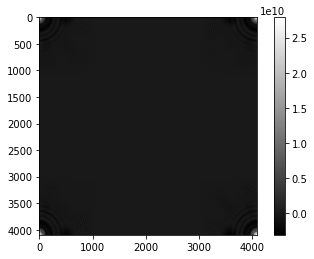

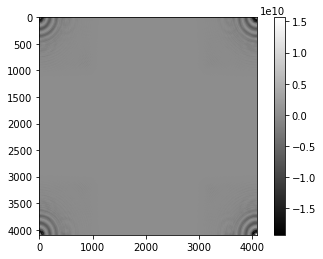

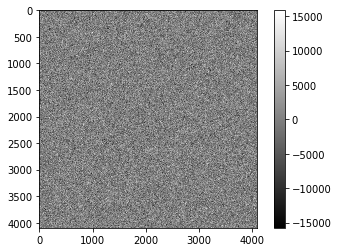

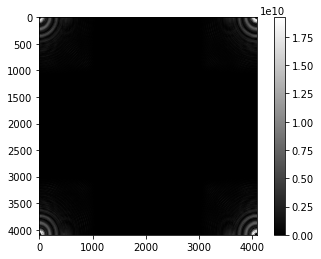

In [23]:
# mz2 = np.load('normalized_30008.npy')
#Displays the calculated results
# z1[1][0][1][1] = 0
# z1[1][0][1][2] = 0
for nn in range(z2[0].shape[0]):
    #-log(P(Sk|I))
#     z1[0][nn,0,0] = 35000
#     z1[0][nn,1,0] = 0
    plt.figure()
    plt.imshow(z2[0][nn,:,:])
    #plt.imshow(z1[0][nn,:,:]/np.amax(z1[0][nn]))
    plt.colorbar()
    #scipy.misc.imsave('30008_A_CTF_' + str(nn) + '.png', z3[0][nn,:,:])
    
for mm in range(z2[0].shape[0]):
#     z1[1][mm,0,0] = 350000
#     z1[1][mm,1,0] = -2200
    #-logP(I|Sk)
    plt.figure()
    plt.imshow(z2[1][mm,:,:])    
    plt.colorbar()

    #scipy.misc.imsave('30008_B_CTF_' + str(mm) + '.png', z3[1][mm,:,:])
    
#-logP(I)
plt.figure()
plt.imshow(z2[2])
plt.colorbar()
#scipy.misc.imsave('30008_C_CTF.png', z3[2])

# for nn in range(z1[0].shape[0]):
#     #P(Sk|I)
#     plt.figure()
#     plt.imshow(z1[3][nn,:,:])
#     plt.colorbar()
#     scipy.misc.imsave('30004_D_3' + str(nn) + '.png', z1[3][nn,:,:])

# dred = z1[0][3,:,:]
# dred = -dred
# dred = dred + 1


# plt.imshow(dred)
# plt.colorbar()
# scipy.misc.imsave('yorkA3_2.png', dred)


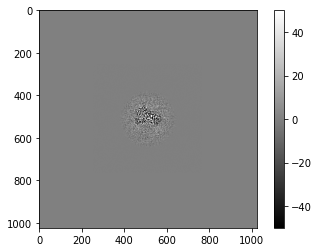

In [18]:
temp = mrc.readMRC(os.path.join(path, 'test_folder_2\\29001_20.mrc'))

plt.figure()
plt.imshow(temp[:,:,1], vmin = -50, vmax = 50)
plt.colorbar()